# Homework 2
**Advanced Optimization Models** \
Lorena Tassone, 18-700-237


In [1]:
# import libraries
import networkx as nx

import gurobipy as gp
from gurobipy import GRB

import numpy as np
import random
import math
import matplotlib.pyplot as plt
import time

## 1. Finding a minimum cost 1-tree in a graph

### a) First approach: 
In the first approach a minimum cost 1-tree in a graph is created by finding the minimum spanning tree (using NetworkX function) plus adding the least cost non-tree edge. 

In [2]:
# Defining function that finds minimum cost 1-tree in a graph (using gurobi, but would also work much easier without optimization!)

info = 1 # =1 if you want to print information, else 0

def min_cost_1_tree_a(graph, info):

    # Find MST using NetworkX
    mst = nx.minimum_spanning_tree(graph)
    if info == 1:
        print('MST:\n', mst.edges(data=True))
    
    # Create new model to find smallest cost non-tree edge (edge in graph but not in MST)
    model_min_cost_edge = gp.Model("min_cost_non_tree_edge")
    model_min_cost_edge.setParam(GRB.Param.OutputFlag, 0)  # Suppress output
    
    # Create binary variable for each non-tree edge 
    edge_vars = {}
    for u, v in graph.edges():
        if not mst.has_edge(u, v):
            edge_vars[u, v] = model_min_cost_edge.addVar(vtype=GRB.BINARY, name=f"e_{u}_{v}")
    if info == 1:
        print('Non-tree edges:\n', edge_vars)

    model_min_cost_edge.update()

    # Set objective function: Minimize the cost of the selected non-tree edge
    obj_fn = gp.quicksum(edge_vars[u, v] * graph[u][v]['weight'] for u, v in edge_vars)
    model_min_cost_edge.setObjective(obj_fn, GRB.MINIMIZE)

    # Add constraint: Only one non-tree edge should be added
    model_min_cost_edge.addConstr(sum(edge_vars.values()) == 1)
    
    # Solve model
    model_min_cost_edge.optimize()

    if model_min_cost_edge.status == GRB.OPTIMAL:
        obj_opt = model_min_cost_edge.objVal
        if info == 1:
            print("Optimal objective value (optimal weight of additional edge):\n", obj_opt)
    
        # Get the selected min cost edge
        for (u, v), var in edge_vars.items():
            if var.X > 0.5:
                wgt = graph[u][v]['weight']
                mst.add_edge(u, v, weight=wgt)
                min_cost = mst.size(weight='weight')
                if info == 1:
                    print('\n1-tree:')
                    print(f'\tAdded minimum cost edge: e=({u},{v}) with weight={wgt}')
                    print(f'\tMinimized costs: {min_cost}')
                    print('\tMinimum cost 1-tree:', mst.edges(data=True))
                break
        return mst, (u, v), min_cost
        
    else:
        print("No solution found!")
        return None

In [3]:
# Defining function that draws the graph and its MST and 1-tree

def draw_graph_with_mst_1tree(graph, mst, additional_edge, title):

    plt.figure()
    
    # Position nodes in concentric circle
    pos = nx.shell_layout(graph)
    
    # Draw all nodes
    nx.draw_networkx_nodes(graph, pos)
    
    # Draw all graph edges in grey
    all_edges = list(graph.edges())
    nx.draw_networkx_edges(graph, pos, edgelist=all_edges, width=1, edge_color='grey', alpha=0.5)
    
    # Highlight MST edges
    mst_edges = list(mst.edges())
    nx.draw_networkx_edges(graph, pos, edgelist=mst_edges, width=2, edge_color='blue')
    
    # Highlight the additional edge for 1-tree
    if additional_edge:
        nx.draw_networkx_edges(graph, pos, edgelist=[additional_edge], width=2, edge_color='red', style='dashed')
    
    # Add weight to edges
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    
    # Draw node labels
    nx.draw_networkx_labels(graph, pos)
    
    plt.title(title)
    # plt.title('Graph with MST (blue) and additional min cost edge (red)')
    plt.show()


In [4]:
## Example graph

# Create graph
n = 5                       # number of nodes
G_1 = nx.complete_graph(n)  # graph with n vertices

G_1[0][1]['weight'] = 2
G_1[0][2]['weight'] = 3
G_1[0][3]['weight'] = 1
G_1[0][4]['weight'] = 5
G_1[1][2]['weight'] = 2
G_1[1][3]['weight'] = 4
G_1[1][4]['weight'] = 6
G_1[2][3]['weight'] = 7
G_1[2][4]['weight'] = 8
G_1[3][4]['weight'] = 9

MST:
 [(0, 3, {'weight': 1}), (0, 1, {'weight': 2}), (0, 4, {'weight': 5}), (1, 2, {'weight': 2})]
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-25
Non-tree edges:
 {(0, 2): <gurobi.Var *Awaiting Model Update*>, (1, 3): <gurobi.Var *Awaiting Model Update*>, (1, 4): <gurobi.Var *Awaiting Model Update*>, (2, 3): <gurobi.Var *Awaiting Model Update*>, (2, 4): <gurobi.Var *Awaiting Model Update*>, (3, 4): <gurobi.Var *Awaiting Model Update*>}
Optimal objective value (optimal weight of additional edge):
 3.0

1-tree:
	Added minimum cost edge: e=(0,2) with weight=3
	Minimized costs: 13.0
	Minimum cost 1-tree: [(0, 3, {'weight': 1}), (0, 1, {'weight': 2}), (0, 4, {'weight': 5}), (0, 2, {'weight': 3}), (1, 2, {'weight': 2})]


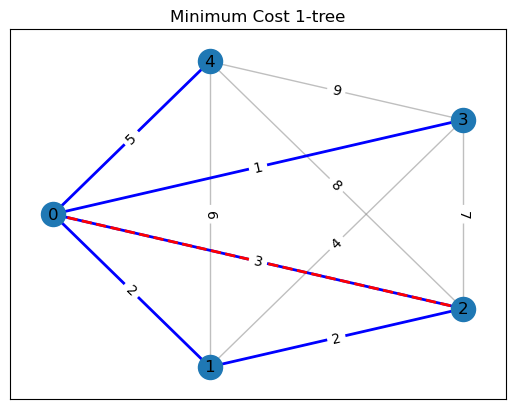

In [5]:
## Testing first approach

# Get min cost 1-tree
tree_a_test, additional_edge_test, min_costs = min_cost_1_tree_a(G_1, info=1)

# Draw min cost 1-tree
draw_graph_with_mst_1tree(G_1, tree_a_test, additional_edge_test, 'Minimum Cost 1-tree')

### b) Second approach: 
For the second approach, to find a minimum cost 1-tree, a modified version of the directed flow formulation ($Q_{flow}$) provided on p.53 of the textbook is used.

We have an undirected graph $G=(V,E)$ with $|V|=n$, $|E|=m$ and edges $e \in E$ with costs $c_e$. \
In the textbook, each edge of the graph is replaced by two directed arcs. Hence, we have a digraph $D=(V,A)$ and arc costs $c_{ij}$ for each arc $(i,j) \in A$.

With root node $r$, the subdigraph of a tree contains a directed path from $r$ to every node $k \in V∖{r}$. One unit of flow can be sent from $r$ to each node $k$.

We modify the formulation in the textbook, such that it works for our undirected graph and results in a minimum cost 1-tree. For this two methods are tested.

#### Method 1

In this first method we modify the textbook formulation by changing the constraint 
$ \sum_{i,j \in A}z_{ij} = n-1 $ into $ \sum_{e \in E}x_{e} = n$, since we now want to find the minimum cost 1-tree which has one more edge than the MST. Further, $x$ and $z$ are binary variables.

</br>

**Variables:**
* $w^k_{ij}=1$ if the unit flow to vertex $k$ uses arc $i,j$ (constinuous variable)
* $z_{ij}=1$ if arc $i,j$ lies on one of the directed paths (binary variable)
* $x_{e}=1$ if edge $e$ is part of the 1-tree, 0 otherwise (binary variable)

**Objective:** \
The objective function minimizes the cost of the 1-tree.
$$
\text { Minimize } \sum_{e \in E} c_{e} x_{e} 
$$

**Subject to:** \
Flow conservation root and non-root node:
$$
\begin{aligned}
-\sum_{j \in V \backslash\{r\}} w_{r j}^k=-1 \quad \text { for } k \in V \backslash\{r\} \\
\sum_{i \in V \backslash\{j\}} w_{i j}^k-\sum_{i \in V \backslash\{j\}} w_{j i}^k=0 \quad \text { for } j, k \in V \backslash\{r\}, j \neq k 
\end{aligned}
$$
Ensure that there is exactly one unit of flow entering node $k$:
$$
\begin{aligned}
\sum_{i \in V \backslash\{k\}} w_{i k}^k & =1 \quad \text { for } k \in V \backslash\{r\} 
\end{aligned}
$$
Limiting flow by path existence:
$$
\begin{aligned}
w_{i j}^k & \leq z_{i j} \quad \text { for }(i, j) \in A, k \in V \backslash\{r\} 
\end{aligned}
$$
Ensuring 1-tree number of edges is $n$:
$$
\begin{aligned}
\sum_{e \in E} x_{e} & = n
\end{aligned}
$$
Relating $x$ and $z$:
$$
\begin{aligned}
x_{e} & =z_{i j}+z_{j i} \quad \text { for } e \in E 
\end{aligned}
$$
No path should directly connect other nodes to the root:
$$
\begin{aligned}
\sum_{j \in V \backslash\{r\}} z_{j r} & =0 
\end{aligned}
$$
Variable bounds:
$$
\begin{aligned}
w \in \mathbb{R}_{+}^{|A|(|V|-1)}, x_e \in\{0,1\} \quad \forall e \in E, z_{ij} \in\{0,1\} \quad \forall (i,j)) \in A
\end{aligned}
$$

In [6]:
# Defining function for 1-tree model: Method 1

info = 1 # =1 if you want to print information, else 0

def min_cost_1_tree_b_1(G, info):

    # root node
    root = 0

    # Make undirected graph directed
    G_directed = nx.DiGraph(G)

    # Extracting edge weights into a dictionary
    costs = {(u, v): G[u][v]['weight'] for u, v in G.edges()}

    # Create new model
    model = gp.Model("min_cost_1_tree_flow")
    model.setParam(GRB.Param.OutputFlag, 0)  # Suppress output
    
    # Defining variables
    n = G.number_of_nodes()
    A = [(i, j) for i, j in G_directed.edges()] 
    
    x = model.addVars(G.edges(), vtype=GRB.BINARY, name="x")
    w = model.addVars(A, G.nodes(), vtype=GRB.CONTINUOUS, name="w", lb=0)
    z = model.addVars(A, vtype=GRB.BINARY, name="z")

    # Set objective function: Minimize the cost
    obj_fn = gp.quicksum(costs[i, j] * x[i, j] for i, j in G.edges())
    model.setObjective(obj_fn, GRB.MINIMIZE)

    # Add constraints
    for k in G.nodes():
        if k != root:
            model.addConstr(-gp.quicksum(w[root, j, k] for j in G.nodes() if j != root) == -1)
            model.addConstr(gp.quicksum(w[i, k, k] for i in G.nodes() if i != k) == 1)
            
            for j in G.nodes():
                if j != root and j != k:
                    model.addConstr(gp.quicksum(w[i, j, k] for i in G.nodes() if i != j) \
                        - gp.quicksum(w[j, i, k] for i in G.nodes() if i != j) == 0)
            
            for i, j in A:
                model.addConstr(w[i, j, k] <= z[i, j])

    model.addConstr(gp.quicksum(x[i, j] for i, j in G.edges()) == n)

    for i, j in G.edges():
        model.addConstr(x[i, j] == z[i, j] + z[j, i])

    model.addConstr(gp.quicksum(z[j, root] for j in G.nodes() if j != root) == 0)

    # Solve model
    model.optimize()

    # Output
    if model.status == GRB.OPTIMAL:
        min_cost = model.objVal
        solution_tree = [(i, j) for i, j in G.edges() if x[i, j].X > 0.5]
        if info == 1:
            print('Minimum cost 1-tree edges:', solution_tree)
            print('Minimized costs:', min_cost)
        return solution_tree, min_cost
    else:
        print("No solution found!")
        return None

Minimum cost 1-tree edges: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2)]
Minimized costs: 13.0


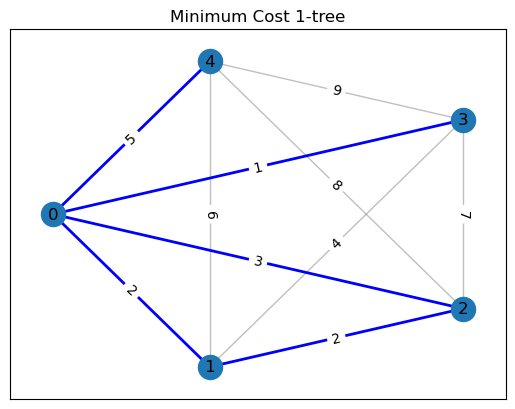

In [7]:
## Testing second approach

# Get min cost 1-tree
tree_b_test_1, min_cost = min_cost_1_tree_b_1(G_1, info=1)

# Draw min cost 1-tree
subgraph_b1 = G_1.edge_subgraph(tree_b_test_1)
draw_graph_with_mst_1tree(G_1, subgraph_b1, None, 'Minimum Cost 1-tree')

#### Method 2

In this second method we add the binary variable $u_e$ for the additional min cost non-tree edge that should be added to the MST. The added constraints are the following:
* $u_e \leq 1-x_e \text { for } e \in E $ ($u_e$ is 1 for non-tree edges)
* $ \sum_{e \in E} u_e = 1$ (only 1 additional edge to MST) 

</br>


**Variables:**
* $w^k_{ij}=1$ if the unit flow to vertex $k$ uses arc $i,j$ (constinuous variable)
* $z_{ij}=1$ if arc $i,j$ lies on one of the directed paths (constinuous variable)
* $x_{e}=1$ if edge $e$ is part of the 1-tree, 0 otherwise (constinuous variable)
* $u_e=1$ if edge $e$ is not part of the 1-tree, 1 otherwise (constinuous variable)

**Objective:** \
The objective function minimizes the cost of the 1-tree.
$$
\text { Minimize } \sum_{e \in E} c_{e} x_{e} \sum_{e \in E} c_{e} u_{e} 
$$

**Subject to:** \
Flow conservation root and non-root node:
$$
\begin{aligned}
-\sum_{j \in V \backslash\{r\}} w_{r j}^k=-1 \quad \text { for } k \in V \backslash\{r\} \\
\sum_{i \in V \backslash\{j\}} w_{i j}^k-\sum_{i \in V \backslash\{j\}} w_{j i}^k=0 \quad \text { for } j, k \in V \backslash\{r\}, j \neq k 
\end{aligned}
$$
Ensure that there is exactly one unit of flow entering node $k$:
$$
\begin{aligned}
\sum_{i \in V \backslash\{k\}} w_{i k}^k & =1 \quad \text { for } k \in V \backslash\{r\} 
\end{aligned}
$$
Limiting flow by path existence:
$$
\begin{aligned}
w_{i j}^k & \leq z_{i j} \quad \text { for }(i, j) \in A, k \in V \backslash\{r\} 
\end{aligned}
$$
Ensuring exactly $n-1$ paths in MST:
$$
\begin{aligned}
\sum_{(i, j) \in A} z_{i j} & = n-1
\end{aligned}
$$
Relating $x$ and $z$:
$$
\begin{aligned}
x_{e} & =z_{i j}+z_{j i} \quad \text { for } e \in E 
\end{aligned}
$$
No path should directly connect other nodes to the root:
$$
\begin{aligned}
\sum_{j \in V \backslash\{r\}} z_{j r} & =0 
\end{aligned}
$$
Additional constraint for adding one additional edge to MST:
$$
\begin{aligned}
u_e \leq 1-x_e \text { for } e \in E \\
\sum_{e \in E} u_e = 1
\end{aligned}
$$
Variable bounds:
$$
\begin{aligned}
w \in \mathbb{R}_{+}^{|A|(|V|-1)}, z \in \mathbb{R}_{+}^{|A|}, x \in[0,1]^{|E|}, u \in[0,1]^{|E|}
\end{aligned}
$$

In [8]:
# Defining function for 1-tree model

info = 1 # =1 if you want to print information, else 0

def min_cost_1_tree_b_2(G, info):

    # Create undirected graph directed
    G_directed = nx.DiGraph(G)

    # Create new model
    model = gp.Model("min_cost_1_tree_flow")
    model.setParam(GRB.Param.OutputFlag, 0)  # Suppress output
    
    # Adding variables
    n = G.number_of_nodes()
    A = list(G_directed.edges())
    E = list(G.edges())
    V = list(G.nodes())
    root = 0 # root node

    w = {(i, j, k): model.addVar(vtype=GRB.CONTINUOUS, name=f'w_{i}_{j}_{k}', lb=0.0) 
         for k in V if k != root for i, j in A}
    z = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, name=f'z_{i}_{j}', lb=0.0) 
         for i, j in A}
    x = {e: model.addVar(vtype=GRB.CONTINUOUS, name=f'x_{e}', lb=0.0, ub=1.0) 
         for e in E}
    u = {e: model.addVar(vtype=GRB.CONTINUOUS, name=f'u_{e}', lb=0.0, ub=1.0) 
         for e in E}

    # Set objective function: Minimize the cost
    obj_fn = gp.quicksum(G.edges[e]['weight'] * (x[e] + u[e]) for e in G.edges())
    model.setObjective(obj_fn, GRB.MINIMIZE)

    # Add constraints
    for k in V:
        if k != root:
            model.addConstr(-gp.quicksum(w[root, j, k] for j in V if (root,j) in A) == -1)
            model.addConstr(gp.quicksum(w[i, k, k] for i in V if i != k) == 1)
            
            for j in V:
                if j != root and j != k:
                    model.addConstr(gp.quicksum(w[i, j, k] for i in V if (i,j) in A) \
                        - gp.quicksum(w[j, i, k] for i in V if (j,i) in A) == 0)
            
            for i, j in A:
                model.addConstr(w[i, j, k] <= z[i, j])

    model.addConstr(gp.quicksum(z[i, j] for i, j in A) == n-1)     

    for i, j in E:
        e = (i,j)
        model.addConstr(x[e] == z[i, j] + z[j, i])
        model.addConstr(u[e] + x[e] <= 1)

    model.addConstr(gp.quicksum(z[j, root] for j in V if (j,root) in A) == 0)
    model.addConstr(gp.quicksum(u[e] for e in E) == 1)

    model.update()
    
    # Solve model
    model.optimize()

    # Output
    if model.status == GRB.OPTIMAL:
        mst = [e for e in E if x[e].X > 0.5]
        non_tree_edge = [e for e in E if u[e].X > 0.5]
        spanning_1tree = mst + non_tree_edge
        min_cost = sum([G.edges[e]['weight'] for e in spanning_1tree])

        if info == 1:
            print('Minimum cost 1-tree edges:', spanning_1tree)
            print('Minimized costs:', min_cost)
        return spanning_1tree, min_cost, non_tree_edge[0]
    
    else:
        print("No solution found!")
        return None

Minimum cost 1-tree edges: [(0, 1), (0, 3), (0, 4), (1, 2), (0, 2)]
Minimized costs: 13


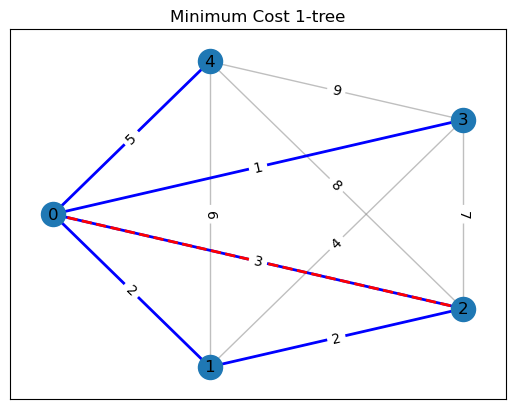

In [9]:
## Testing second approach

# Get min cost 1-tree
tree_b_test_2, min_cost, non_tree_edge = min_cost_1_tree_b_2(G_1, info=1)

# Draw min cost 1-tree
subgraph_b2 = G_1.edge_subgraph(tree_b_test_2)
draw_graph_with_mst_1tree(G_1, subgraph_b2, non_tree_edge, 'Minimum Cost 1-tree')

### c)  Formulation Comparison
Experiment with randomly generated network instances to make sure that the results provided by a) and b) with respect to
the obtained objective functions values coincide.

In [10]:
## Check if results of example graph G_1 from above coincide for the three formulations above

# Fromulation a
tree_edges_a = [e for e in tree_a_test.edges()]
print('Fromulation a: ', tree_edges_a)
# Formulation b, method 1
print('Fromulation b.1: ', tree_b_test_1)
# Formulation b, method 2
print('Fromulation b.2: ', tree_b_test_2)

print('\nFromulation b.1=b.2? ', set(tree_b_test_1) == set(tree_b_test_2))
print('Fromulation a=b.1? ', set(tree_edges_a) == set(tree_b_test_1))

Fromulation a:  [(0, 3), (0, 1), (0, 4), (0, 2), (1, 2)]
Fromulation b.1:  [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2)]
Fromulation b.2:  [(0, 1), (0, 3), (0, 4), (1, 2), (0, 2)]

Fromulation b.1=b.2?  True
Fromulation a=b.1?  True


Instance 1: Results coincide (Value: [(0, 8), (1, 2), (2, 4), (2, 8), (3, 5), (3, 9), (4, 5), (4, 8), (5, 6), (5, 7)])
Instance 2: Results coincide (Value: [(0, 1), (0, 8), (0, 9), (1, 2), (1, 7), (2, 4), (3, 6), (3, 7), (4, 6), (5, 6)])
Instance 3: Results coincide (Value: [(0, 3), (0, 4), (0, 9), (1, 7), (2, 8), (3, 6), (3, 8), (4, 7), (5, 6), (6, 7)])
Instance 4: Results coincide (Value: [(0, 4), (0, 6), (1, 7), (2, 4), (2, 5), (2, 9), (3, 5), (3, 8), (4, 6), (5, 7)])
Instance 5: Results coincide (Value: [(0, 2), (1, 5), (1, 7), (1, 8), (2, 5), (2, 7), (3, 8), (4, 9), (5, 9), (6, 8)])
Instance 6: Results differ 
 	Formulation a: [(0, 5), (1, 6), (2, 3), (2, 5), (3, 8), (4, 9), (5, 7), (6, 7), (7, 8), (7, 9)] 
 	Formulation b: [(0, 5), (1, 6), (2, 5), (2, 6), (3, 8), (4, 9), (5, 7), (6, 7), (7, 8), (7, 9)]
	Min cost coincide!
Instance 7: Results coincide (Value: [(0, 2), (0, 6), (0, 9), (1, 5), (2, 4), (2, 8), (3, 5), (4, 9), (5, 7), (5, 8)])
Instance 8: Results coincide (Value: [(0,

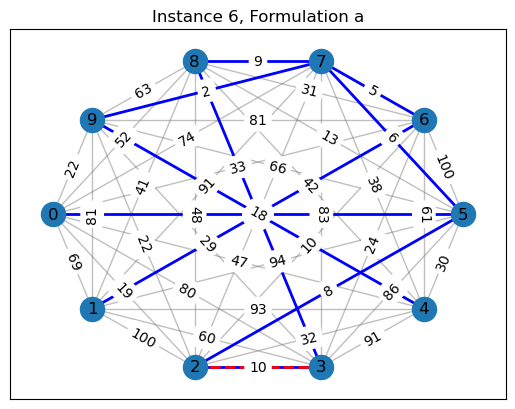

In [14]:
## Experiment with randomly generated network instances

num_instances = 20
num_nodes = 10
weight_range = (1, 100)
root = 1

# Generating random graphs
def generate_random_complete_graph(num_nodes, weight_range=(1, 100)):

    # Create graph
    G_random = nx.complete_graph(num_nodes)

    # Assigning random weights between 1 and 100
    for (u, v) in G_random.edges():
        G_random[u][v]['weight'] = random.randint(*weight_range) 

    return G_random

    

# Experiment
coincide = 0
differ = 0
differ_graphs = {}

for _ in range(num_instances):

    # random complete graph
    G_random = generate_random_complete_graph(num_nodes, weight_range)

    # First approach a)
    tree_a, additional_edge, min_cost_a = min_cost_1_tree_a(G_random, info=0)      
    edges_a = [e for e in tree_a.edges()]
    edges_a = sorted(edges_a)

    # Second approach b)
    # edges_b, min_cost_b = min_cost_1_tree_b_1(G_random, info=0)                   # method 1
    edges_b, min_cost_b, non_tree_edge_b = min_cost_1_tree_b_2(G_random, info=0)    # method 2
    edges_b = sorted(edges_b)
    
    if edges_a == edges_b:
        coincide += 1
        print(f"Instance {_+1}: Results coincide (Value: {edges_a})")
    else:
        differ += 1
        print(f"Instance {_+1}: Results differ \n \tFormulation a: {edges_a} \n \tFormulation b: {edges_b}")
        if min_cost_a == min_cost_b:
            print("\tMin cost coincide!")
        else:
            if min_cost_a < min_cost_b:
                print(f"Min cost DON'T coincide! Formulation a has lower cost ({min_cost_a}) than formulatiion b ({min_cost_b})")
            else:
                print(f"Min cost DON'T coincide! Formulation b has lower cost ({min_cost_b}) than formulatiion a ({min_cost_a})")
            
        differ_graphs[f"Instance {_+1}, Formulation a"] = [G_random, tree_a,  additional_edge]


print(f'\nResults coincide {coincide}/{num_instances} times.')
print(f'Results differ {differ}/{num_instances} times.')


# Show graphs for which solution does not coincide
for title, graph in differ_graphs.items():
    draw_graph_with_mst_1tree(graph[0], mst=graph[1], additional_edge=graph[2], title=title)

For the comparison formulation b method 2 is used. However, formulation b method 1 was tested as well and gives the same results.

With every execution of the code the number of not coincinding solutions varies between 0 an 3. However, in most cases the results coincide. \
If we have a look at the printed output and the respective graphs, we can see that the not coinciding results differ only because of the usage of one different edge which has the same costs. In this shown example, Formulation a used the edge (2,3) whereas Formulation b uses (2,6), which both have cost 10.

This is due to the defined algorithm that only gives one possible solution as output and does not differentiate between equal cost edges. One could create graphs with unique costs, or extend the algorithm such that he gives all possible solutions as output.
However, for the not coinciding instances, the minimized costs coincide in all results, showing that the two formulations a) and b) are equal.



## 2. Minimum cost 1-tree providing lower bound for optimal cost of TSP problem

In this section the quality of the minimum cost 1-tree lower bound for TSP is explored, using randomly generated network instances of varying sizes. \
Further, the running time of the approaches in a), b) and the exact TSP are compared.

#### Symmetric Traveling Salesman Problem (STSP)
Symmetric Traveling Salesman Problem (STSP, here sometimes called TSP) specified by an undirected graph $G=(V,E)$ and edge weights $c_e$ for $e \in E$, where $e=(i,j)=(j,i)$. \
The problem is to find an undirected tour of minimum weight.

</br>

**Variables:** 
* $c_e$: cost (or distance) associated with each edge $e \in E$
* $x_e$: 1 if edge $e$ is included in the tour, 0 otherwise


**Objective:** \
The objective function minimizes the travel time.
$$
\min \sum_{e \in E} c_e \cdot x_e
$$



**Subject to:** \
Each city should touch the tour twice (enter-and-leave):
$$
\sum_{e \in \delta(i)} x_e=2 \quad \forall i \in V
$$
where $\delta(i)$ represents the set of edges incident to node $i$. \
Subtour elimination:
$$
\sum_{(i,j) \in E(S)} x_{i,j} \leq|S|-1 \quad \text { for } S \subset V, 2 \leq|S| \leq |V|-1 \\
$$
where $E(S)$ is the set of edges in the subgraph induced by S. \
Binary decision variables:
$$
x_e \in\{0,1\} \quad \forall e \in E
$$

#### TSP with and without minimum cost 1-tree lower bound

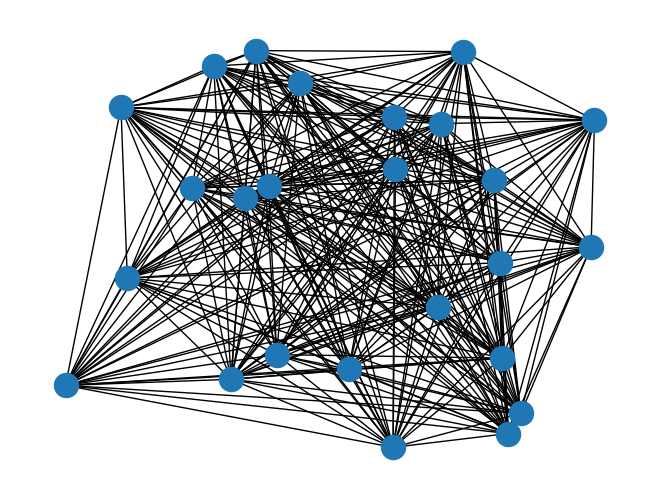

In [15]:
## Setup example graph

n = 25                      # number of cities
G_2 = nx.complete_graph(n)  # graph with a vertex for each city

# for convenience, pick the city (x,y)-coordinates at random
my_pos = { i : ( random.random(), random.random() ) for i in G_2.nodes } # pos[i] = (x_i, y_i)
nx.draw(G_2, pos=my_pos)

# for convenience, suppose that distances are Euclidean
def eucl_dist(x1,y1,x2,y2):
    return math.sqrt( (x1-x2)**2 + (y1-y2)**2 )

for i,j in G_2.edges:
    (x1,y1) = my_pos[i]
    (x2,y2) = my_pos[j]
    G_2.edges[i,j]['weight'] = eucl_dist(x1,y1,x2,y2)

Subtour constraints prevent multiple loops in a TSP tour. Because there are an exponential number of these constraints, we don't want to add them all to the model. Instead, we use a callback function to find violated subtour constraints and add them to the model as lazy constraints

In [16]:
## create a function to separate the subtour elimination constraints
def subtour_elimination(m, where):
    
    # check if LP relaxation at this branch-and-bound node has an integer solution
    if where == GRB.Callback.MIPSOL: 
        
        # retrieve the LP solution
        xval = m.cbGetSolution(m._x)
        
        # which edges are selected?
        tour_edges = [ e for e in m._G.edges if xval[e] > 0.5 ]
        
        # for each subtour, add a constraint
        for component in nx.connected_components( m._G.edge_subgraph( tour_edges ) ):
            
            if len(component) <= m._G.number_of_nodes() / 2:
                
                inner_edges = [ (i,j) for (i,j) in m._G.edges if i in component and j in component ]
                m.cbLazy( gp.quicksum( m._x[e] for e in inner_edges ) <= len(component) - 1 )

In [17]:
## TSP optimization function

draw = 1        # draw=1 if you want to draw the graph, 0 if not

def tsp(G, draw):
    
    # Create new model
    model = gp.Model()
    model.setParam('OutputFlag', 0) # Suppress solver output

    # Define variables
    x = model.addVars(G.edges, vtype=GRB.BINARY, name="x")

    # Set objective function 
    # # Start with the 2-matching (assignment) relaxation
    model.setObjective(gp.quicksum(G.edges[e]['weight'] * x[e] for e in G.edges), GRB.MINIMIZE)

    # Add constraints 
    # # Each city should touch the tour twice (enter-and-leave)
    model.addConstrs(gp.quicksum(x[e] for e in G.edges if e in G.edges(i)) == 2 for i in G.nodes)

    model.update()

    # # tell Gurobi that we will be adding (lazy) constraints
    model.Params.lazyConstraints = 1

    # # designate the callback routine to be subtour_elimination()
    model._callback = subtour_elimination

    # add the variables and graph to our model object, for use in the callback
    model._x = x
    model._G = G

    # solve the MIP with our callback
    model.optimize(model._callback)

    min_cost = model.objVal
    
    # get edges and draw graph
    tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]
    if draw == 1:
        print(f'\tMinimized costs TSP: {min_cost}')
        print('\tTour edges: ', tour_edges)
        nx.draw(G.edge_subgraph(tour_edges), pos=my_pos)

    return min_cost, tour_edges


	Minimized costs TSP: 4.314782622229921
	Tour edges:  [(0, 18), (0, 22), (1, 5), (1, 8), (2, 6), (2, 20), (3, 4), (3, 9), (4, 23), (5, 24), (6, 13), (7, 12), (7, 18), (8, 17), (9, 16), (10, 11), (10, 23), (11, 19), (12, 17), (13, 21), (14, 16), (14, 20), (15, 21), (15, 24), (19, 22)]


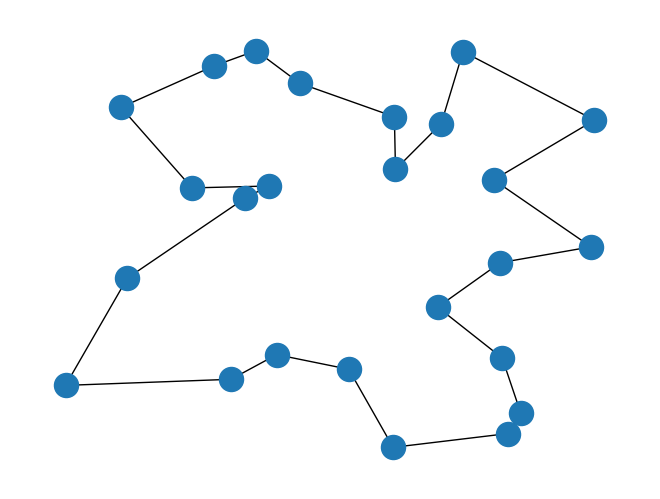

In [18]:
min_cost, tour_edges = tsp(G_2, draw)

#### Exploring quality of lower bound 
As stated on p.29 of the textbook, the 1-tree minimum cost serve as a lower bound for the STSP minimum costs:
$$
\begin{aligned}
& Z^{S T S P}=\min _{T \subseteq E}\left\{\sum_{e \in T} c_e: T \text { forms a tour }\right\} \geq \\
& Z^{1-\text { tree }}=\min _{T \subseteq E}\left\{\sum_{e \in T} c_e: T \text { forms a 1-tree }\right\} 
\end{aligned}
$$

To assess the quality of this lower bound, the difference between the TSP minimum costs and 1-tree minimum costs is computed and plotted for different graphs with increasing number of nodes:
$$
Z^{STSP}-Z^{1-tree}
$$


In [19]:
# Function generating random complete graphs with euclidean distances/weights

def random_graph(n):
    # graph with a vertex for each city
    G_random = nx.complete_graph(n)

    # for convenience, pick the city (x,y)-coordinates at random
    points = {i: (random.random(), random.random()) for i in G_random.nodes } # pos[i] = (x_i, y_i)

    # Euclidean distances/weights
    for i,j in G_random.edges:
        (x1,y1) = points[i]
        (x2,y2) = points[j]
        G_random.edges[i,j]['weight'] = eucl_dist(x1,y1,x2,y2)
    
    return G_random

In [20]:
# Experiment: Min cost difference and running time
sizes = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 80, 90, 100]

tsp_exact_time = {}
formulation_1tree_a_time = {}
formulation_1tree_b1_time = {}
formulation_1tree_b2_time = {}

diff = {}

for n in sizes:

    # random graph
    G_random_2 = random_graph(n)

    # TSP exact
    start_tsp_exact = time.time()
    min_cost_tsp, tour_edges_tsp = tsp(G_random_2, draw=0) 
    time_tsp_exact = time.time() - start_tsp_exact
    tsp_exact_time[n] = time_tsp_exact

    # 1-tree formulation a
    start_1tree_a = time.time()
    tree_a_test, additional_edge_test, min_costs_1tree_a = min_cost_1_tree_a(G_random_2, info=0)
    time_1tree_a = time.time() - start_1tree_a
    formulation_1tree_a_time[n] = time_1tree_a

    # 1-tree formulation b.1
    start_1tree_b1 = time.time()
    tree_b_test_1, min_cost_1tree_b1 = min_cost_1_tree_b_1(G_random_2, info=0)   
    time_1tree_b1 = time.time() - start_1tree_b1
    formulation_1tree_b1_time[n] = time_1tree_b1

    # 1-tree formulation b.2
    start_1tree_b2 = time.time()
    tree_b_test_2, min_cost_1tree_b2, non_tree_edge_b2 = min_cost_1_tree_b_2(G_random_2, info=0)   
    time_1tree_b2 = time.time() - start_1tree_b2
    formulation_1tree_b2_time[n] = time_1tree_b2

    # Compute and store difference in min cost
    d = min_cost_tsp - min_costs_1tree_a
    diff[n] = d

    # Output
    print(f"\nSize: {n}")
    print("Min. Cost:")
    print(f"\tTSP: {min_cost_tsp}")
    print(f"\t1-tree formulation a: {min_costs_1tree_a}")
    print(f"\t1-tree formulation b.1: {min_cost_1tree_b1}")
    print(f"\t1-tree formulation b.2: {min_cost_1tree_b2}")
    print(f"Difference: {d}")
    print("------")





Size: 10
Min. Cost:
	TSP: 2.943347440546833
	1-tree formulation a: 2.496683867735564
	1-tree formulation b.1: 2.4966838677355634
	1-tree formulation b.2: 2.4966838677355634
Difference: 0.4466635728112691
------

Size: 15
Min. Cost:
	TSP: 3.9809391070903324
	1-tree formulation a: 3.218107003716508
	1-tree formulation b.1: 3.218107003716508
	1-tree formulation b.2: 3.218107003716508
Difference: 0.7628321033738246
------

Size: 20
Min. Cost:
	TSP: 4.314773437816853
	1-tree formulation a: 3.363536547858785
	1-tree formulation b.1: 3.363536547858785
	1-tree formulation b.2: 3.363536547858785
Difference: 0.9512368899580679
------

Size: 25
Min. Cost:
	TSP: 4.059702502024257
	1-tree formulation a: 3.4920399209631414
	1-tree formulation b.1: 3.4920399209631405
	1-tree formulation b.2: 3.492039920963141
Difference: 0.567662581061116
------

Size: 30
Min. Cost:
	TSP: 4.776895135968822
	1-tree formulation a: 4.020017295530661
	1-tree formulation b.1: 4.0200172955306614
	1-tree formulation b.2: 4

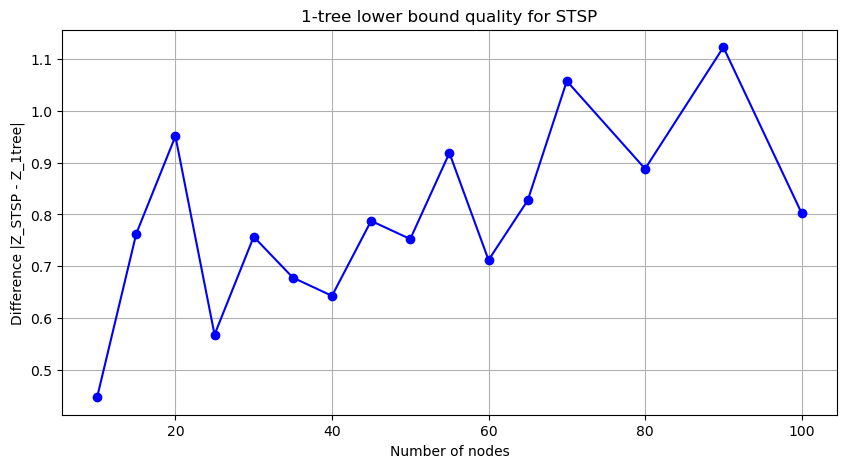

In [21]:
# Plotting min cost difference |Z_STSP - Z_1tree|
keys = tsp_exact_time.keys()
diff_values = list(diff.values())

plt.figure(figsize=(10, 5))
plt.plot(keys, diff_values, marker='o', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Number of nodes')
plt.ylabel('Difference |Z_STSP - Z_1tree|')
plt.title('1-tree lower bound quality for STSP')

# Show plot
plt.grid(True)
plt.show()

As we can see in the plot above, $Z^{STSP}-Z^{1-tree}$ is always positive showing that in fact $Z^{1-tree}$ is a lower bound for $Z^{STSP}$. \
 Further we can see that with increasing number of nodes, this difference increases as well. Hence, the quality of the lower bound decreases with the number of nodes in the graph. \
 However, the difference does not get large, showing its peak at 90 nodes with a difference of around 1.1. Hence, for all the tested number of nodes, the quality of the lower bound is still good.

#### Exploring running time

{10: 0.0059795379638671875, 15: 0.0059986114501953125, 20: 0.016999244689941406, 25: 0.018001794815063477, 30: 0.055624961853027344, 35: 0.0455937385559082, 40: 0.07556891441345215, 45: 0.10277771949768066, 50: 0.20652079582214355, 55: 0.23032641410827637, 60: 0.31006431579589844, 65: 0.30339980125427246, 70: 0.5317680835723877, 80: 0.46294474601745605, 90: 1.2013661861419678, 100: 1.3171615600585938}
{10: 0.0010001659393310547, 15: 0.0019998550415039062, 20: 0.002001523971557617, 25: 0.001998424530029297, 30: 0.003057241439819336, 35: 0.004976511001586914, 40: 0.007990121841430664, 45: 0.009007453918457031, 50: 0.009050607681274414, 55: 0.013682842254638672, 60: 0.012999296188354492, 65: 0.01681375503540039, 70: 0.025606870651245117, 80: 0.022763729095458984, 90: 0.04551839828491211, 100: 0.07569503784179688}
{10: 0.019013166427612305, 15: 0.06399774551391602, 20: 0.24979019165039062, 25: 0.7213263511657715, 30: 1.5956907272338867, 35: 4.599794387817383, 40: 10.90360426902771, 45: 24.

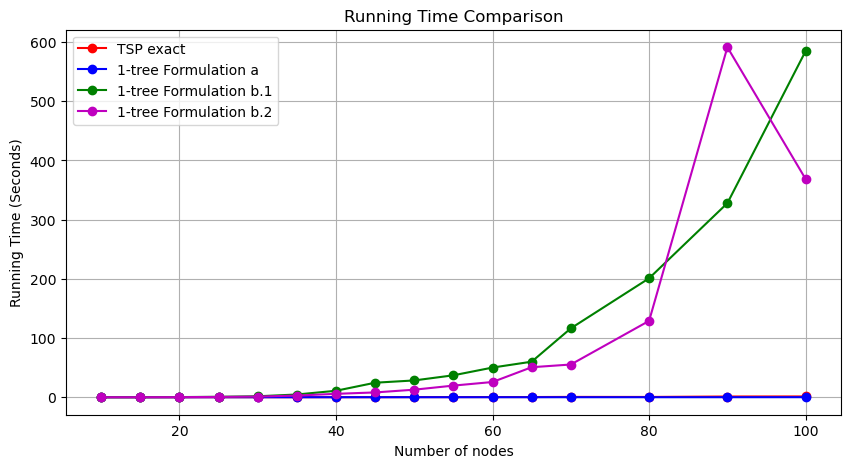

In [22]:
# Running time comparison
print(tsp_exact_time)
print(formulation_1tree_a_time)
print(formulation_1tree_b1_time)
print(formulation_1tree_b2_time)

# Plotting running time
keys = tsp_exact_time.keys()
tsp_time_values = list(tsp_exact_time.values())
tree_a_time_values = list(formulation_1tree_a_time.values())
tree_b1_time_values = list(formulation_1tree_b1_time.values())
tree_b2_time_values = list(formulation_1tree_b2_time.values())

plt.figure(figsize=(10, 5))
plt.plot(keys, tsp_time_values, marker='o', linestyle='-', color='r', label='TSP exact')
plt.plot(keys, tree_a_time_values, marker='o', linestyle='-', color='b', label='1-tree Formulation a')
plt.plot(keys, tree_b1_time_values, marker='o', linestyle='-', color='g', label='1-tree Formulation b.1')
plt.plot(keys, tree_b2_time_values, marker='o', linestyle='-', color='m', label='1-tree Formulation b.2')

# Adding labels and title
plt.xlabel('Number of nodes')
plt.ylabel('Running Time (Seconds)')
plt.title('Running Time Comparison')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

**Running time** \
In the plot the actual algorithm running time in seconds is plotted. \
As we can see, both 1-tree formulations for b) increase strongly with the number of nodes. Wherease the computation time for the 1-tree formulation a and the exact TSP exact remains low and increases only a little compared to formulations b). This result can be explained by the higher number of calculations that must be excecuted in the 1-tree formulation b) (Directed Flow) algorithm, due to the digraph.

</br>

**Size of problem instance** \
We have a randomly generated complete undirected graph $G=(V,E)$ with $|V|=n, |E|=\frac{n*(n-1)}{2}=m$ and $c_e \forall e \in E$. \
We also have a randomly generated complete directed graph $DG=(V,A)$ with $|V|=n, |A|=n*(n-1)=d$ and $c_{ij} \forall (i,j) \in A$. \
Hence the input size in terms of Big-O notation is for both $\Omicron(m)=\Omicron(d)=\Omicron(n^2)$. 

* **Exact TSP**: 
    * In general, if the number of cities of the TSP is $n$ , then the possible number of routes is $n!$. Since there are an exponential number of constraints $(2^n-2)$ to eliminate cycles, we use lazy constraints to dynamically eliminate those cycles.
    * So we have: $C=max\{c_e, |S|-1|e \in E, S \subset V, 2 \leq|S| \leq |V|-1\}$. 
    * Hence the input size is: $\Omicron(m*log(C)) = \Omicron(n^2*log(C))$.

* **Formulation a)**:
    * Finding MST: NetworkX's 'minimum_spanning_tree' function employs Kruskal's algorithm with complexity $\Omicron(n^2*log(n))$
    * Finding minimum cost non-tree edge we have the complexity $\Omicron(n^2)$, since:
        * Creating binary variables for each non-tree edge: $\Omicron(n^2)$ (as in the worst case all edges are non-tree edges)
        * Setting the objective function: $\Omicron(n^2)$ (as we go through each edge to set up the objective function)
    * Constructing 1-tree: Adding the minimum cost edge to the MST is of complexity $\Omicron(n)$
    * Overall complexity: $\Omicron(n^2*log(n))$

* **Formulation b)**: 
    


## Bonus
Formal proof that a minimum cost 1-tree in a graph can be found by finding the minimum spanning tree plus the least cost non-tree edge.

**Proof**: \
A minimum cost 1-tree in a connected graph $G=(V,E)$ with $n$ vertices is a subgraph that includes all vertices and exactly $n$ edges, forming a tree with one additional edge, and has minimum possible total edge cost. 
* First we have to show, that a 1-tree exists as a subgraph of $G$. Since $G$ is conneted, it has a spanning tree. Adding any additional edge to this spanning tree will form a 1-tree.
* We denote the minimum cost 1-tree as $T_{min}$ with costs $C_{min}$. $T_{MST}$ is a Minimum Spanning Tree (MST) of $G$ with costs $C_{MST}$. $e$ is the least cost non-tree edge w.r.t. $T_{MST}$ with costs $C_e$.
* We want to show that $C_{min}$ = $C_{MST}$ + $C_e$.
* First, we show that $T_{min}$ contains $T_{MST}$ and $e$:
    * By definition, $T_{min}$ has one more edge than $T_{MST}$.
    * Since adding $e$ to $T_{MST}$ creates a cycle, and removing any other edge from this cycle will result in a spanning tree, $T_{min}$ must contain $T_{MST}$ and $e$. Hence, we showed that $C_{min} \geq C_{MST} + C_{e}$.
* Second, we show that there does not exist a cheaper 1-tree:
    * By contradiction, we assume that there exists another 1-tree $T'_{min}$ with costs $C_{T'_{min}} < C_{MST} + C_e$. Since $T'_{min}$ is a 1-tree, it must contain a spanning tree $T'_{ST}$ and one additional edge e', implying:
        * $C_{T'_{min}} = C_{T'_{ST}} + C_{e'}$
        * $C_{T'_{ST}} \geq C_{MST}$ since $T_{MST}$ is a MST
        * $C_{e'} \geq C_e$ since $e$ is the least cost non-tree edge w.r.t. $T_{MST}$.
    * So we get  $C_{T'_{min}} \geq C_{MST} + C_{e}$, which contradicts our assumption. 
    * Therefore, there does not exist a cheaper 1-tree and $C_{min} = C_{MST} + C_{e}$.
        